In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

%pylab inline
import pickle
import numpy as np
import os
import DifferentiableHOS as DHOS
import tensorflow as tf
from scipy import ndimage, misc
import matplotlib.patches as mpatches
from DifferentiableHOS.Fisher import fisher
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from chainconsumer import ChainConsumer
import cmasher as cmr

Populating the interactive namespace from numpy and matplotlib


In [2]:
field_size=5.
field_npix=1024
pix_scale = 5/1024*60

In [3]:
kmaps = []
for filename in os.listdir("/pscratch/sd/d/dlan/result_paper_IA_0/maps/"):
        res =pickle.load(open(os.path.join('/pscratch/sd/d/dlan/result_paper_IA_0/maps/', filename), 'rb'))
        kmaps.append(res['kmap'])

2022-09-16 01:06:40.084174: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-16 01:06:40.085079: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: login22
2022-09-16 01:06:40.085104: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: login22
2022-09-16 01:06:40.085657: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.48.7
2022-09-16 01:06:40.085705: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.48.7
2022-09-16 01:06:40.085709: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.48.7
2022-09-16 01:06:40.097260: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

In [4]:
def rebin(a, shape):
    sh = shape, a.shape[0] // shape
    return tf.math.reduce_mean(tf.reshape(a, sh), axis=-1)

In [5]:
from flowpm.fourier_smoothing import fourier_smoothing
def desc_y1_analysis(kmap):
    """
  Adds noise and apply smoothing we might expect in DESC Y1 SRD setting
  """
    ngal = 10
    pix_scale = field_size / field_npix * 60
    ngal_per_pix = ngal * pix_scale**2
    sigma_e = 0.26 / np.sqrt(2 * ngal_per_pix)
    kmap = kmap + sigma_e * tf.random.normal(kmap.shape)
    return kmap

In [6]:
bins=tf.linspace(-.1, 1.,8)
rangev=[-.1,1.]
pcounts_5_6_7=[]
ps=[]
for i in range(len(kmaps)):
    kmap = desc_y1_analysis(kmaps[i])
    ell,p=DHOS.statistics.power_spectrum_mulscale(kmap, field_size,field_npix)
    ell = ell[2:46]
    p = p[2:46]
    ell = rebin(ell, 11)
    p = rebin(p, 11)
    counts_5_6_7,bins_=DHOS.statistics.peaks_histogram_tf_mulscale(kmap,nscales=7,bins=bins)
    counts_5_6_7=counts_5_6_7[4:7]
    pcounts_5_6_7.append(counts_5_6_7)
    ps.append(p)

2022-09-16 01:08:47.835429: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [7]:
ps = stack(ps, axis=0)
pcounts_5_6_7 = stack(pcounts_5_6_7, axis=0)

In [8]:
ps_mean=ps.mean(axis=0)
pcounts_mean_5_6_7=pcounts_5_6_7.mean(axis=0)

In [9]:
ps_jac= []
for filename in os.listdir("/pscratch/sd/d/dlan/result_paper_IA_0/jac_ps_multiscale"):
        res =pickle.load(open(os.path.join('/pscratch/sd/d/dlan/result_paper_IA_0/jac_ps_multiscale', filename), 'rb'))
        ps_jac.append(res['jac'])
        
        
pcounts_jac_5_6_7 = []
for filename in os.listdir("/pscratch/sd/d/dlan/result_paper_IA_0/jac_peakcounts"):
        res =pickle.load(open(os.path.join('/pscratch/sd/d/dlan/result_paper_IA_0/jac_peakcounts', filename), 'rb'))
        pcounts_jac_5_6_7 .append(res['jac'])

In [10]:
ps_jac= stack(ps_jac, axis=0)
pcounts_jac_5_6_7 = stack(pcounts_jac_5_6_7, axis=0)

# Results without IA

In [178]:
# Computing covariance matrix
f_sky=25/150000

cov_ps=np.cov(tf.reshape(ps,[len(ps),11]), rowvar=False)*f_sky
cov_pcounts_5_6_7=np.cov(tf.reshape(pcounts_5_6_7[:,:,:],[len(pcounts_5_6_7),24]), rowvar=False)*f_sky



dmu_ps = ps_jac[:,...,:6].mean(axis=0)
dmu_pcounts_5_6_7 = tf.reshape(pcounts_jac_5_6_7[:,:,:,:6],[len(pcounts_jac_5_6_7),24,6]).numpy().mean(axis=0)


Fpcounts_5_6_7 = dmu_pcounts_5_6_7.T @ (np.linalg.inv(cov_pcounts_5_6_7)) @ dmu_pcounts_5_6_7
Fps = dmu_ps.T @ (np.linalg.inv(cov_ps)) @ dmu_ps

fisher_object_pcounts_5_6_7 = fisher(Fpcounts_5_6_7, labels,  fid_cosmo)
fisher_object_ps = fisher(Fps, labels,  fid_cosmo)

In [179]:
fid_params=np.array([0.2589, 0.8159, 0.04860, 0.9667, 0.6774, -1.0])

In [180]:
col = cmr.eclipse([0.,0,0.55,0.85]) 

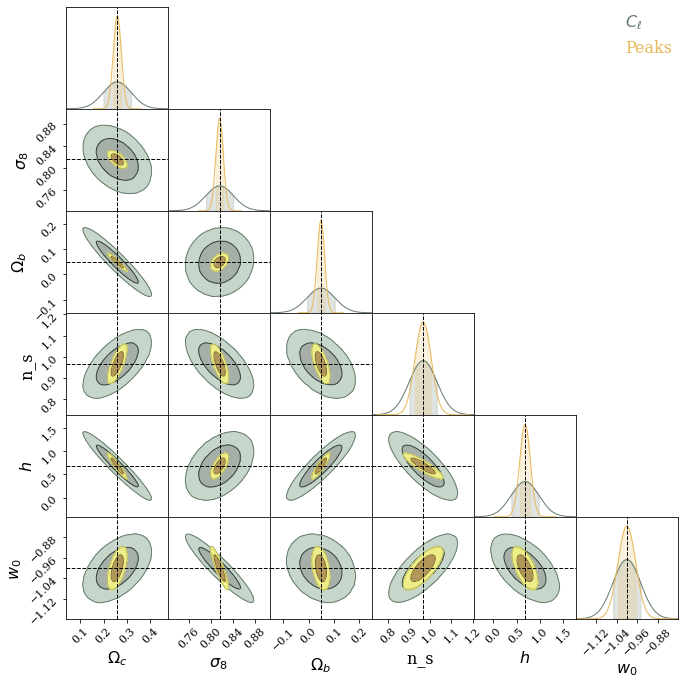

In [181]:
c = ChainConsumer()
c.add_covariance(fid_params , np.linalg.inv(Fps), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","n_s","$h$","$w_0$"], name="$C_{\ell}$")
c.add_covariance(fid_params , np.linalg.inv(Fpcounts_5_6_7), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","n_s","$h$","$w_0$"], name="Peaks")
c.configure(usetex=False, shade=[True, True], shade_alpha=[0.5,0.8], bar_shade=[True,True],colors=[col[2], col[3]],tick_font_size=11,label_font_size=16)
fig = c.plotter.plot(figsize="column", truth=fid_params)
fig.set_size_inches(5 + fig.get_size_inches())
plt.savefig('../figures/Fisher.pdf',bbox_inches='tight')


## Add a prior

In [182]:
def compute_prior_matrix(params,params_prior,sigma):
    n = len(params)
    P = np.zeros((n,n))
    for i, param in enumerate(params_prior):
            P[i,i] = 1./sigma[i]**2
    return P

In [183]:
sigma=np.array([0.2,0.14,0.006,0.08,0.063,0.8])

In [184]:
P=compute_prior_matrix(fid_params,fid_params,sigma)

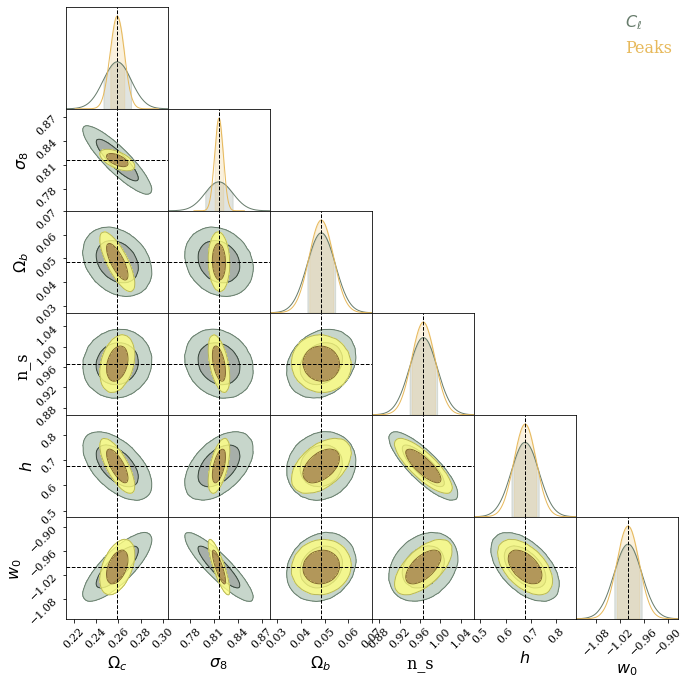

In [185]:
c = ChainConsumer()
c.add_covariance(fid_params , np.linalg.inv(Fps+P), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","n_s","$h$","$w_0$"], name="$C_{\ell}$")
c.add_covariance(fid_params , np.linalg.inv(Fpcounts_5_6_7+P), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","n_s","$h$","$w_0$"], name="Peaks")
c.configure(usetex=False, shade=[True, True], shade_alpha=[0.5,0.8], bar_shade=[True,True],colors=[col[2], col[3]],tick_font_size=11,label_font_size=16)
fig = c.plotter.plot(figsize="column", truth=fid_params)
fig.set_size_inches(5 + fig.get_size_inches())
plt.savefig('../figures/Fisher_prior.pdf',bbox_inches='tight')


# Results with IA 

In [186]:
fid_params_IA=np.array([0.2589, 0.8159, 0.04860, 0.9667, 0.6774, -1.0, 0.])

In [187]:
# Computing covariance matrix

cov_ps=np.cov(tf.reshape(ps,[len(ps),11]), rowvar=False)*f_sky
cov_pcounts_5_6_7=np.cov(tf.reshape(pcounts_5_6_7[:,:,:],[len(pcounts_5_6_7),24]), rowvar=False)*f_sky


dmu_ps_IA = ps_jac.mean(axis=0)
dmu_pcounts_IA_5_6_7 = tf.reshape(pcounts_jac_5_6_7[:,:,:,:],[len(pcounts_jac_5_6_7),24,7]).numpy().mean(axis=0)


Fps_IA = dmu_ps_IA.T @ (np.linalg.inv(cov_ps)) @ dmu_ps_IA
Fpcounts_IA_5_6_7 = dmu_pcounts_IA_5_6_7.T @ (np.linalg.inv(cov_pcounts_5_6_7)) @ dmu_pcounts_IA_5_6_7



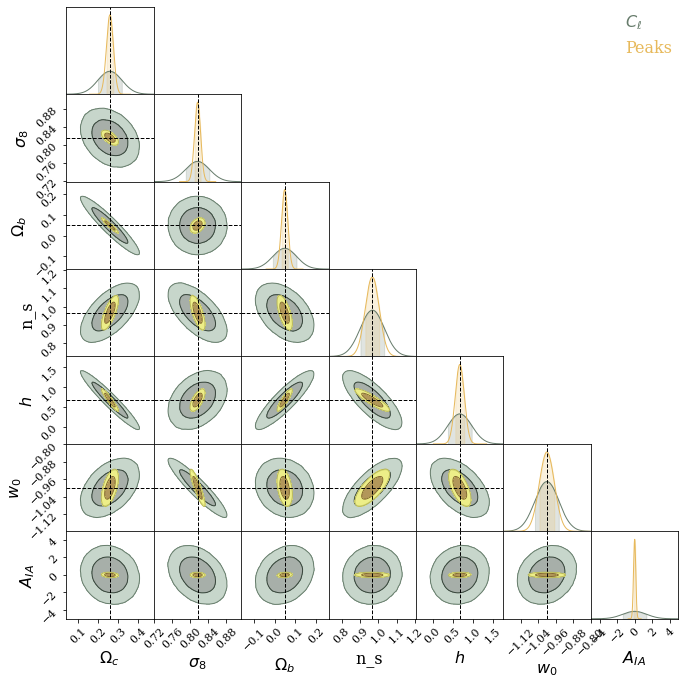

In [188]:
c_IA = ChainConsumer()
c_IA.add_covariance(fid_params_IA , np.linalg.inv(Fps_IA), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","n_s","$h$","$w_0$", "$A_{IA}$"], name="$C_{\ell}$")
c_IA.add_covariance(fid_params_IA , np.linalg.inv(Fpcounts_IA_5_6_7), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","n_s","$h$","$w_0$", "$A_{IA}$"], name="Peaks")
c_IA.configure(usetex=False, shade=[True, True], shade_alpha=[0.5,0.8], bar_shade=[True,True],colors=[col[2], col[3]],tick_font_size=11,label_font_size=16)
fig = c_IA.plotter.plot(figsize="column", truth=fid_params)
fig.set_size_inches(5 + fig.get_size_inches())
plt.savefig('../figures/Fisher_IA.pdf')


## Add a prior

In [189]:
P_IA=compute_prior_matrix(fid_params_IA,fid_params,sigma)

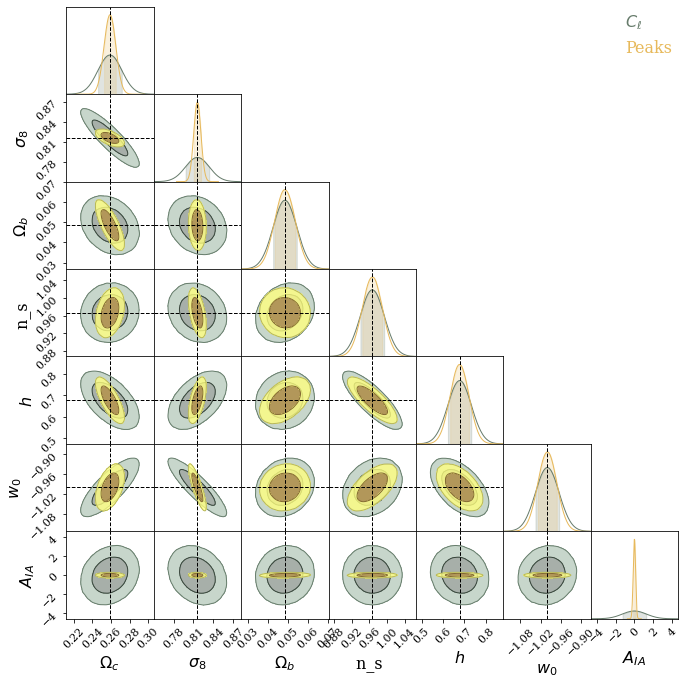

In [190]:
c_IA = ChainConsumer()
c_IA.add_covariance(fid_params_IA , np.linalg.inv(Fps_IA+P_IA), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","n_s","$h$","$w_0$", "$A_{IA}$"], name="$C_{\ell}$")
c_IA.add_covariance(fid_params_IA , np.linalg.inv(Fpcounts_IA_5_6_7+P_IA), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","n_s","$h$","$w_0$", "$A_{IA}$"], name="Peaks")
c_IA.configure(usetex=False, shade=[True, True], shade_alpha=[0.5,0.8], bar_shade=[True,True],colors=[col[2], col[3]],tick_font_size=11,label_font_size=16)
fig = c_IA.plotter.plot(figsize="column", truth=fid_params)
fig.set_size_inches(5 + fig.get_size_inches())
plt.savefig('../figures/Fisher_IA_prior.pdf')
